# Roadblock Scenario Simulation – Howest Traffic Project

This notebook reuses the trained Random Forest models and feature
engineering from `RandomForestRegressor.ipynb` to simulate roadblock
scenarios per street and per hour.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

# nicer style
plt.style.use("seaborn-v0_8")

# load data + models exactly as in RF notebook
df = pd.read_parquet("models/df_model.parquet")
models = joblib.load("models/models.pkl")
targets = joblib.load("models/targets.pkl")
feature_cols = joblib.load("models/feature_cols.pkl")

# make sure datetime is datetime
df["date_x"] = pd.to_datetime(df["date_x"])


/home/hadi/tf/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.8.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/hadi/tf/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.8.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [2]:
street_name = "Sintmartenslatemlaan"      # user choice
selected_date = pd.to_datetime("2026-01-20").date()   # user picks ONE date
start_hour = 10                             # user picks start hour
end_hour = 12                               # user picks end hour (inclusive)

print(street_name, selected_date, start_hour, end_hour)


Sintmartenslatemlaan 2026-01-20 10 12


In [3]:
# --- build 24‑hour future for the selected date, single street ---

street_name = "Sintmartenslatemlaan"
selected_date = pd.to_datetime("2026-01-20").date()

# 1) filter to this street and make datetime naive
df_street = df[df["street_name"] == street_name].copy()
df_street["date_x"] = pd.to_datetime(df_street["date_x"]).dt.tz_localize(None)

# 2) build a naive 24h index for that calendar day
day_start = pd.Timestamp(selected_date)          # 2026-01-06 00:00
day_index = pd.date_range(day_start, periods=24, freq="H")

future = pd.DataFrame({"datetime": day_index})
future["date_only"] = future["datetime"].dt.date
future["hour"] = future["datetime"].dt.hour
future["dayofweek"] = future["datetime"].dt.dayofweek
future["is_weekend"] = future["dayofweek"].isin([5, 6]).astype(int)

# 3) calendar features (make df_street calendar dates naive too)
df_street["date_y"] = pd.to_datetime(df_street["date_y"]).dt.date
df_street["date"] = pd.to_datetime(df_street["date"]).dt.date

cal_holidays = (
    df_street[["date_y", "is_holiday"]]
    .drop_duplicates()
    .rename(columns={"date_y": "date_only"})
)
future = future.merge(cal_holidays, on="date_only", how="left")
future["is_holiday"] = future["is_holiday"].fillna(0).astype(int)

cal_vac = (
    df_street[["date", "is_school_vacation"]]
    .drop_duplicates()
    .rename(columns={"date": "date_only"})
)
future = future.merge(cal_vac, on="date_only", how="left")
future["is_school_vacation"] = future["is_school_vacation"].fillna(0).astype(int)

# 4) weather profile per hour
weather_cols = ["temperature_c", "precipitation_mm", "cloud_cover_pct", "wind_speed_kmh"]
hourly_weather = (
    df_street.groupby("hour")[weather_cols]
    .median()
    .reset_index()
)
future = future.merge(hourly_weather, on="hour", how="left")

# 5) street code
street_code_value = df_street["street_code"].iloc[0]
future["street_code"] = street_code_value

future_X = future[feature_cols]
future.head()


/tmp/ipykernel_359692/2464113542.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  day_index = pd.date_range(day_start, periods=24, freq="H")


,datetime,date_only,hour,dayofweek,is_weekend,is_holiday,is_school_vacation,temperature_c,precipitation_mm,cloud_cover_pct,wind_speed_kmh,street_code
0,2026-01-20 00:00:00,2026-01-20,0,1,0,0,0,4.30,0.0,86.0,11.80,1
1,2026-01-20 01:00:00,2026-01-20,1,1,0,0,0,4.55,0.0,98.5,12.35,1
2,2026-01-20 02:00:00,2026-01-20,2,1,0,0,0,4.20,0.0,100.0,12.45,1
3,2026-01-20 03:00:00,2026-01-20,3,1,0,0,0,4.20,0.0,99.5,12.45,1
4,2026-01-20 04:00:00,2026-01-20,4,1,0,0,0,4.40,0.0,100.0,12.70,1


In [4]:
future_preds = future[["datetime"]].copy()
for t in targets:
    rf = models[t]
    future_preds[f"pred_{t}"] = rf.predict(future_X)

# rename for convenience
future_preds["car"] = future_preds["pred_car"]
future_preds["bike"] = future_preds["pred_bike"]
future_preds["pedestrian"] = future_preds["pred_pedestrian"]
future_preds["heavy"] = future_preds["pred_heavy"]
future_preds["total"] = future_preds["pred_total_people"]


In [5]:
def apply_roadblock_day(df_preds, start_h, end_h):
    df_rb = df_preds.copy()
    hours = df_rb["datetime"].dt.hour
    mask = hours.between(start_h, end_h)

    # assumptions – tweak later
    df_rb.loc[mask, "car"]        *= 0.1
    df_rb.loc[mask, "heavy"]      *= 0.2
    df_rb.loc[mask, "bike"]       *= 0.8
    df_rb.loc[mask, "pedestrian"] *= 0.9

    df_rb.loc[mask, "total"] = (
        df_rb.loc[mask, "car"]
        + df_rb.loc[mask, "bike"]
        + df_rb.loc[mask, "pedestrian"]
    )
    return df_rb

future_rb = apply_roadblock_day(future_preds, start_hour, end_hour)


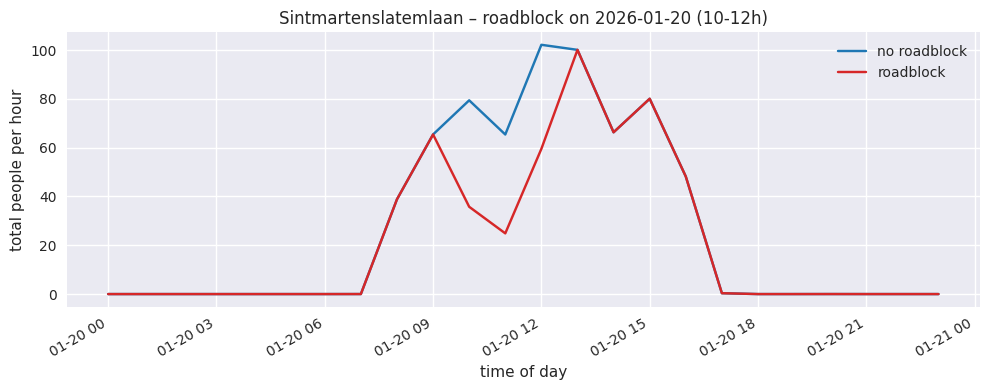

In [6]:
fig, ax = plt.subplots(figsize=(10,4))

ax.plot(future_preds["datetime"], future_preds["total"],
        label="no roadblock", color="tab:blue")
ax.plot(future_rb["datetime"], future_rb["total"],
        label="roadblock", color="tab:red")

ax.set_title(f"{street_name} – roadblock on {selected_date} ({start_hour}-{end_hour}h)")
ax.set_xlabel("time of day")
ax.set_ylabel("total people per hour")
ax.legend()
fig.autofmt_xdate()
plt.tight_layout()
plt.show()


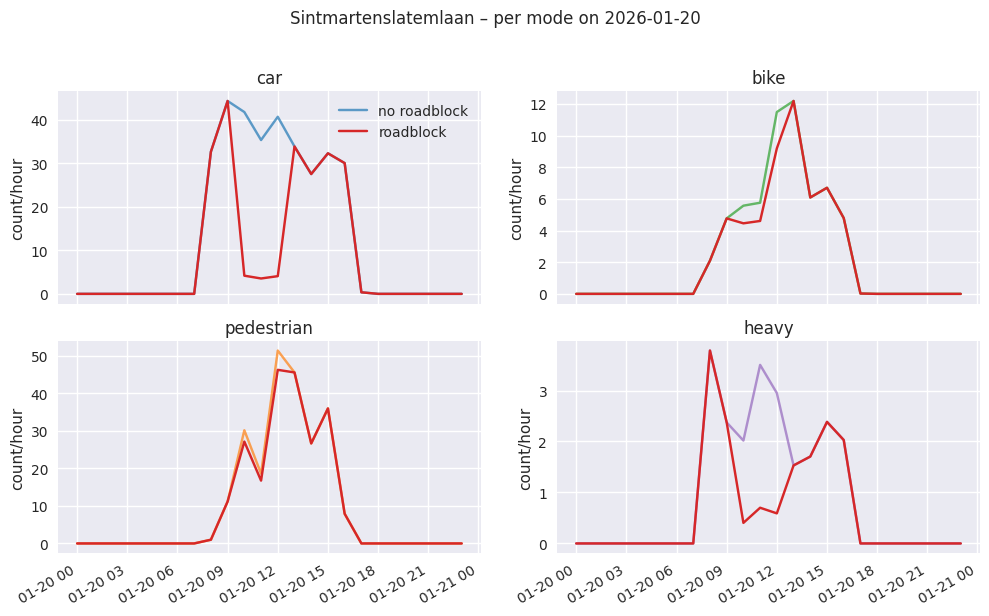

In [7]:
modes = ["car", "bike", "pedestrian", "heavy"]
colors = {"car": "tab:blue", "bike": "tab:green",
          "pedestrian": "tab:orange", "heavy": "tab:purple"}

fig, axes = plt.subplots(2, 2, figsize=(10,6), sharex=True)
axes = axes.ravel()

for ax, m in zip(axes, modes):
    ax.plot(future_preds["datetime"], future_preds[m],
            label="no roadblock", color=colors[m], alpha=0.7)
    ax.plot(future_rb["datetime"], future_rb[m],
            label="roadblock", color="tab:red")
    ax.set_title(m)
    ax.set_ylabel("count/hour")

axes[0].legend()
fig.suptitle(f"{street_name} – per mode on {selected_date}", y=1.02)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()


In [8]:
# restrict to roadblock window
mask_rb = future_preds["datetime"].dt.hour.between(start_hour, end_hour)

# peak within the blocked hours ONLY
baseline_peak = future_preds.loc[mask_rb, "total"].max()
rb_peak = future_rb.loc[mask_rb, "total"].max()
peak_drop_pct = 100 * (baseline_peak - rb_peak) / baseline_peak

# whole‑day totals (all 24h)
baseline_sum = future_preds["total"].sum()
rb_sum = future_rb["total"].sum()
day_drop_pct = 100 * (baseline_sum - rb_sum) / baseline_sum

print(f"On {selected_date} between {start_hour}:00 and {end_hour}:00:")
print(f"- Peak total traffic without roadblock: {baseline_peak:.1f} people/hour")
print(f"- Peak total traffic with roadblock:   {rb_peak:.1f} people/hour")
print(f"- Peak reduction: {peak_drop_pct:.1f}%")

print()
print(f"Over the whole day on {selected_date}:")
print(f"- Total people without roadblock: {baseline_sum:.0f}")
print(f"- Total people with roadblock:   {rb_sum:.0f}")
print(f"- Overall reduction: {day_drop_pct:.1f}%")


On 2026-01-20 between 10:00 and 12:00:
- Peak total traffic without roadblock: 102.1 people/hour
- Peak total traffic with roadblock:   59.5 people/hour
- Peak reduction: 41.7%

Over the whole day on 2026-01-20:
- Total people without roadblock: 646
- Total people with roadblock:   519
- Overall reduction: 19.6%


# Enhanced Visualization Functions

These functions create publication-ready charts suitable for analysis and dashboards.

In [9]:
def build_roadblock_insights(future_base, future_rb, selected_date, start_hour, end_hour):
    """
    Generates markdown-formatted insights about roadblock impact.
    
    Parameters:
    -----------
    future_base : pd.DataFrame
        Baseline predictions with columns: datetime, car, bike, pedestrian, heavy, total
    future_rb : pd.DataFrame
        Roadblock scenario with same columns
    selected_date : date
        The date being analyzed
    start_hour : int
        Roadblock start hour (0-23)
    end_hour : int
        Roadblock end hour (0-23)
    
    Returns:
    --------
    str : Markdown-formatted insights
    """
    # Get hours
    hours = future_base["datetime"].dt.hour
    mask_rb = (hours >= start_hour) & (hours <= end_hour)
    
    # Peak comparison during roadblock window
    baseline_peak = future_base.loc[mask_rb, "total"].max()
    rb_peak = future_rb.loc[mask_rb, "total"].max()
    peak_drop_pct = 100 * (baseline_peak - rb_peak) / baseline_peak if baseline_peak > 0 else 0
    
    # Whole day totals
    baseline_sum = future_base["total"].sum()
    rb_sum = future_rb["total"].sum()
    day_drop_pct = 100 * (baseline_sum - rb_sum) / baseline_sum if baseline_sum > 0 else 0
    
    # Per-mode analysis during roadblock window
    modes = {
        "car": "🚗 Cars",
        "bike": "🚲 Bikes",
        "pedestrian": "🚶 Pedestrians",
        "heavy": "🚛 Heavy Vehicles"
    }
    
    mode_insights = []
    for mode_key, mode_label in modes.items():
        avg_base = future_base.loc[mask_rb, mode_key].mean()
        avg_rb = future_rb.loc[mask_rb, mode_key].mean()
        
        if avg_base > 0:
            change_pct = 100 * (avg_rb - avg_base) / avg_base
            change_sign = "+" if change_pct > 0 else ""
            mode_insights.append(
                f"  - **{mode_label}**: {avg_base:.1f} → {avg_rb:.1f} per hour "
                f"(**{change_sign}{change_pct:.1f}%**)"
            )
        else:
            mode_insights.append(f"  - **{mode_label}**: No significant traffic")
    
    # Build markdown string
    insight_md = f"""## 📊 Roadblock Impact Analysis

### 🎯 Key Findings for {selected_date.strftime('%B %d, %Y')}

**Roadblock Period:** {start_hour}:00 - {end_hour}:00

#### Peak Hour Impact (During Roadblock)
- **Without Roadblock:** {baseline_peak:.0f} people/hour
- **With Roadblock:** {rb_peak:.0f} people/hour  
- **Peak Reduction:** **-{peak_drop_pct:.1f}%** 🔴

#### Full Day Impact (All 24 Hours)
- **Total Without Roadblock:** {baseline_sum:.0f} people
- **Total With Roadblock:** {rb_sum:.0f} people
- **Overall Reduction:** **-{day_drop_pct:.1f}%**

---

### 🚦 Impact by Transportation Mode
**Average hourly traffic during roadblock period ({start_hour}:00 - {end_hour}:00):**

{chr(10).join(mode_insights)}

---

### 💡 Summary
During the **{end_hour - start_hour + 1}-hour roadblock**, car traffic drops significantly by **{100 * (future_base.loc[mask_rb, "car"].mean() - future_rb.loc[mask_rb, "car"].mean()) / future_base.loc[mask_rb, "car"].mean():.0f}%**, while bike traffic decreases by only **{abs(100 * (future_base.loc[mask_rb, "bike"].mean() - future_rb.loc[mask_rb, "bike"].mean()) / future_base.loc[mask_rb, "bike"].mean()):.0f}%**. The roadblock causes an overall daily traffic reduction of **{day_drop_pct:.1f}%**.
"""
    
    return insight_md

In [10]:
def plot_per_mode_roadblock_day(future_base, future_rb, selected_date, street_name, start_hour, end_hour):
    """
    Creates a 2x2 grid showing per-mode traffic impact.
    
    Parameters:
    -----------
    future_base : pd.DataFrame
        Baseline predictions with columns: datetime, car, bike, pedestrian, heavy
    future_rb : pd.DataFrame
        Roadblock scenario with same columns
    selected_date : date
        The date being analyzed
    street_name : str
        Name of the street
    start_hour : int
        Roadblock start hour (0-23)
    end_hour : int
        Roadblock end hour (0-23)
    
    Returns:
    --------
    matplotlib.figure.Figure
    """
    modes = ["car", "bike", "pedestrian", "heavy"]
    mode_labels = {
        "car": "🚗 Cars",
        "bike": "🚲 Bikes", 
        "pedestrian": "🚶 Pedestrians",
        "heavy": "🚛 Heavy Vehicles"
    }
    mode_colors = {
        "car": "#3498DB",      # Blue
        "bike": "#27AE60",     # Green
        "pedestrian": "#E67E22", # Orange
        "heavy": "#9B59B6"     # Purple
    }
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
    axes = axes.ravel()
    
    hours = future_base["datetime"].dt.hour
    
    for idx, (ax, mode) in enumerate(zip(axes, modes)):
        # Plot baseline with mode-specific color
        ax.fill_between(hours, future_base[mode], alpha=0.25, 
                         color=mode_colors[mode])
        ax.plot(hours, future_base[mode], color=mode_colors[mode], 
                linewidth=2.5, marker='o', markersize=4, 
                label='Normal Traffic', alpha=0.8)
        
        # Plot roadblock scenario in red
        ax.plot(hours, future_rb[mode], color='#E74C3C', 
                linewidth=2.5, marker='s', markersize=4, 
                label='With Roadblock', linestyle='--')
        
        # Highlight roadblock window
        ax.axvspan(start_hour, end_hour, alpha=0.12, color='red')
        
        # Formatting
        ax.set_title(mode_labels[mode], fontsize=13, fontweight='bold', pad=10)
        ax.set_ylabel('Count per Hour', fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
        ax.set_xlim(-0.5, 23.5)
        
        # Only show legend on first subplot
        if idx == 0:
            ax.legend(loc='upper left', fontsize=10, framealpha=0.95)
        
        # Calculate average drop in roadblock window
        mask = (hours >= start_hour) & (hours <= end_hour)
        avg_base = future_base.loc[mask, mode].mean()
        avg_rb = future_rb.loc[mask, mode].mean()
        if avg_base > 0:
            drop_pct = 100 * (avg_base - avg_rb) / avg_base
            
            # Add text box with percentage drop
            textstr = f'Avg Drop:\n{drop_pct:.0f}%'
            props = dict(boxstyle='round', facecolor='white', 
                        edgecolor=mode_colors[mode], linewidth=2, alpha=0.9)
            ax.text(0.98, 0.97, textstr, transform=ax.transAxes,
                   fontsize=10, fontweight='bold', verticalalignment='top',
                   horizontalalignment='right', bbox=props, color=mode_colors[mode])
    
    # Set x-axis labels on bottom row
    for ax in axes[2:]:
        ax.set_xlabel('Time of Day', fontsize=11, fontweight='bold')
        ax.set_xticks(range(0, 25, 3))
        ax.set_xticklabels([f'{h:02d}:00' for h in range(0, 25, 3)])
    
    fig.suptitle(f'Traffic Impact by Mode on {selected_date.strftime("%Y-%m-%d")} – {street_name}\n'
                 f'Roadblock from {start_hour}:00 to {end_hour}:00',
                 fontsize=16, fontweight='bold', y=0.995)
    
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    return fig

In [11]:
def plot_total_roadblock_day(future_base, future_rb, selected_date, street_name, start_hour, end_hour):
    """
    Creates an attractive line chart comparing total traffic with and without roadblock.
    
    Parameters:
    -----------
    future_base : pd.DataFrame
        Baseline predictions with columns: datetime, total
    future_rb : pd.DataFrame
        Roadblock scenario with columns: datetime, total
    selected_date : date
        The date being analyzed
    street_name : str
        Name of the street
    start_hour : int
        Roadblock start hour (0-23)
    end_hour : int
        Roadblock end hour (0-23)
    
    Returns:
    --------
    matplotlib.figure.Figure
    """
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Extract hour for x-axis
    hours = future_base["datetime"].dt.hour
    
    # Plot baseline as filled area
    ax.fill_between(hours, future_base["total"], alpha=0.3, 
                     color='#4A90E2', label='Normal Traffic')
    ax.plot(hours, future_base["total"], color='#4A90E2', 
            linewidth=2.5, marker='o', markersize=5)
    
    # Plot roadblock scenario with strong red
    ax.plot(hours, future_rb["total"], color='#E74C3C', 
            linewidth=3, marker='s', markersize=6, label='With Roadblock')
    
    # Highlight roadblock time window with shaded background
    ax.axvspan(start_hour, end_hour, alpha=0.15, color='red', 
               label=f'Roadblock Period ({start_hour}:00-{end_hour}:00)')
    
    # Formatting
    ax.set_xlabel('Time of Day', fontsize=13, fontweight='bold')
    ax.set_ylabel('Total People per Hour', fontsize=13, fontweight='bold')
    ax.set_title(f'Traffic Impact on {selected_date.strftime("%Y-%m-%d")} – {street_name}\n'
                 f'Roadblock from {start_hour}:00 to {end_hour}:00',
                 fontsize=15, fontweight='bold', pad=20)
    
    # Set x-axis to show hours
    ax.set_xticks(range(0, 25, 3))
    ax.set_xticklabels([f'{h:02d}:00' for h in range(0, 25, 3)])
    ax.set_xlim(-0.5, 23.5)
    
    # Grid and legend
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
    ax.legend(loc='upper left', fontsize=11, framealpha=0.95)
    
    # Add percentage drop annotation at peak hour
    peak_hour_idx = future_base["total"].idxmax()
    peak_hour = future_base.loc[peak_hour_idx, "datetime"].hour
    if start_hour <= peak_hour <= end_hour:
        baseline_val = future_base.loc[peak_hour_idx, "total"]
        rb_val = future_rb.loc[peak_hour_idx, "total"]
        drop_pct = 100 * (baseline_val - rb_val) / baseline_val
        
        ax.annotate(f'-{drop_pct:.0f}%', 
                   xy=(peak_hour, rb_val),
                   xytext=(peak_hour, baseline_val * 0.7),
                   fontsize=12, fontweight='bold', color='#E74C3C',
                   ha='center',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                            edgecolor='#E74C3C', linewidth=2),
                   arrowprops=dict(arrowstyle='->', color='#E74C3C', lw=2))
    
    plt.tight_layout()
    return fig

# Demo: Using the Enhanced Visualizations

Now let's use these improved functions with our data.

In [12]:
# Generate markdown insights
insights_md = build_roadblock_insights(
    future_preds, 
    future_rb, 
    selected_date, 
    start_hour, 
    end_hour
)
print(insights_md)

## 📊 Roadblock Impact Analysis

### 🎯 Key Findings for January 20, 2026

**Roadblock Period:** 10:00 - 12:00

#### Peak Hour Impact (During Roadblock)
- **Without Roadblock:** 102 people/hour
- **With Roadblock:** 60 people/hour  
- **Peak Reduction:** **-41.7%** 🔴

#### Full Day Impact (All 24 Hours)
- **Total Without Roadblock:** 646 people
- **Total With Roadblock:** 519 people
- **Overall Reduction:** **-19.6%**

---

### 🚦 Impact by Transportation Mode
**Average hourly traffic during roadblock period (10:00 - 12:00):**

  - **🚗 Cars**: 39.3 → 3.9 per hour (**-90.0%**)
  - **🚲 Bikes**: 7.6 → 6.1 per hour (**-20.0%**)
  - **🚶 Pedestrians**: 33.4 → 30.0 per hour (**-10.0%**)
  - **🚛 Heavy Vehicles**: 2.8 → 0.6 per hour (**-80.0%**)

---

### 💡 Summary
During the **3-hour roadblock**, car traffic drops significantly by **90%**, while bike traffic decreases by only **20%**. The roadblock causes an overall daily traffic reduction of **19.6%**.



/tmp/ipykernel_359692/3484664976.py:94: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.98])
/tmp/ipykernel_359692/3484664976.py:94: UserWarning: Glyph 128690 (\N{BICYCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.98])
/tmp/ipykernel_359692/3484664976.py:94: UserWarning: Glyph 128694 (\N{PEDESTRIAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.98])
/tmp/ipykernel_359692/3484664976.py:94: UserWarning: Glyph 128667 (\N{ARTICULATED LORRY}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.98])
/home/hadi/tf/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hadi/tf/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128690 (\N{BICYCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_fi

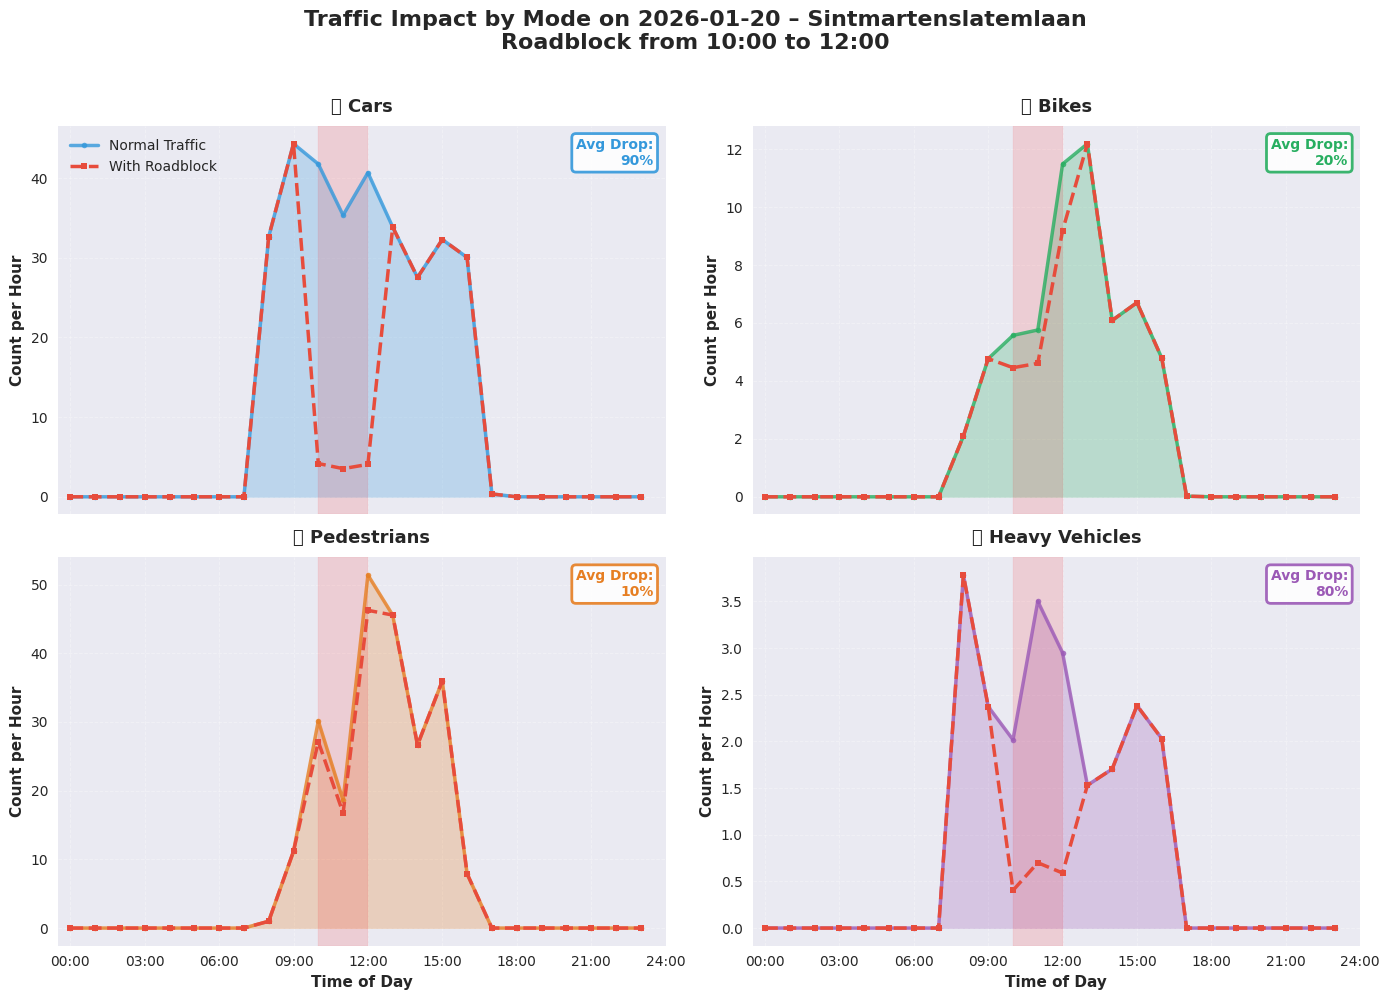

In [13]:
# Generate enhanced per-mode comparison chart
fig2 = plot_per_mode_roadblock_day(
    future_preds, 
    future_rb, 
    selected_date, 
    street_name, 
    start_hour, 
    end_hour
)
plt.show()

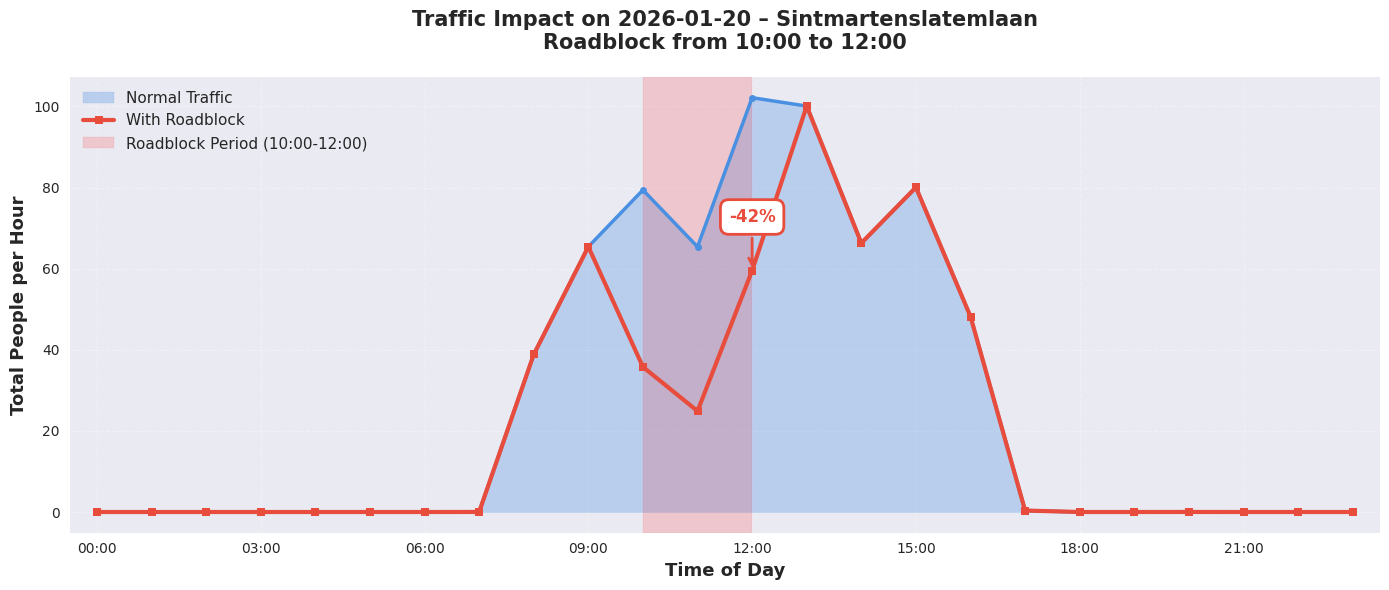

In [14]:
# Generate enhanced total traffic chart
fig1 = plot_total_roadblock_day(
    future_preds, 
    future_rb, 
    selected_date, 
    street_name, 
    start_hour, 
    end_hour
)
plt.show()

# Demo: Using the Enhanced Visualizations

Now let's use these improved functions with our data.

In [15]:
def build_roadblock_insights(future_base, future_rb, selected_date, start_hour, end_hour):
    """
    Generates markdown-formatted insights about roadblock impact.
    
    Parameters:
    -----------
    future_base : pd.DataFrame
        Baseline predictions with columns: datetime, car, bike, pedestrian, heavy, total
    future_rb : pd.DataFrame
        Roadblock scenario with same columns
    selected_date : date
        The date being analyzed
    start_hour : int
        Roadblock start hour (0-23)
    end_hour : int
        Roadblock end hour (0-23)
    
    Returns:
    --------
    str : Markdown-formatted insights
    """
    # Get hours
    hours = future_base["datetime"].dt.hour
    mask_rb = (hours >= start_hour) & (hours <= end_hour)
    
    # Peak comparison during roadblock window
    baseline_peak = future_base.loc[mask_rb, "total"].max()
    rb_peak = future_rb.loc[mask_rb, "total"].max()
    peak_drop_pct = 100 * (baseline_peak - rb_peak) / baseline_peak if baseline_peak > 0 else 0
    
    # Whole day totals
    baseline_sum = future_base["total"].sum()
    rb_sum = future_rb["total"].sum()
    day_drop_pct = 100 * (baseline_sum - rb_sum) / baseline_sum if baseline_sum > 0 else 0
    
    # Per-mode analysis during roadblock window
    modes = {
        "car": "🚗 Cars",
        "bike": "🚲 Bikes",
        "pedestrian": "🚶 Pedestrians",
        "heavy": "🚛 Heavy Vehicles"
    }
    
    mode_insights = []
    for mode_key, mode_label in modes.items():
        avg_base = future_base.loc[mask_rb, mode_key].mean()
        avg_rb = future_rb.loc[mask_rb, mode_key].mean()
        
        if avg_base > 0:
            change_pct = 100 * (avg_rb - avg_base) / avg_base
            change_sign = "+" if change_pct > 0 else ""
            mode_insights.append(
                f"  - **{mode_label}**: {avg_base:.1f} → {avg_rb:.1f} per hour "
                f"(**{change_sign}{change_pct:.1f}%**)"
            )
        else:
            mode_insights.append(f"  - **{mode_label}**: No significant traffic")
    
    # Build markdown string
    insight_md = f"""## 📊 Roadblock Impact Analysis

### 🎯 Key Findings for {selected_date.strftime('%B %d, %Y')}

**Roadblock Period:** {start_hour}:00 - {end_hour}:00

#### Peak Hour Impact (During Roadblock)
- **Without Roadblock:** {baseline_peak:.0f} people/hour
- **With Roadblock:** {rb_peak:.0f} people/hour  
- **Peak Reduction:** **-{peak_drop_pct:.1f}%** 🔴

#### Full Day Impact (All 24 Hours)
- **Total Without Roadblock:** {baseline_sum:.0f} people
- **Total With Roadblock:** {rb_sum:.0f} people
- **Overall Reduction:** **-{day_drop_pct:.1f}%**

---

### 🚦 Impact by Transportation Mode
**Average hourly traffic during roadblock period ({start_hour}:00 - {end_hour}:00):**

{chr(10).join(mode_insights)}

---

### 💡 Summary
During the **{end_hour - start_hour + 1}-hour roadblock**, car traffic drops significantly by **{100 * (future_base.loc[mask_rb, "car"].mean() - future_rb.loc[mask_rb, "car"].mean()) / future_base.loc[mask_rb, "car"].mean():.0f}%**, while bike traffic decreases by only **{abs(100 * (future_base.loc[mask_rb, "bike"].mean() - future_rb.loc[mask_rb, "bike"].mean()) / future_base.loc[mask_rb, "bike"].mean()):.0f}%**. The roadblock causes an overall daily traffic reduction of **{day_drop_pct:.1f}%**.
"""
    
    return insight_md

In [16]:
def plot_per_mode_roadblock_day(future_base, future_rb, selected_date, street_name, start_hour, end_hour):
    """
    Creates a 2x2 grid showing per-mode traffic impact.
    
    Parameters:
    -----------
    future_base : pd.DataFrame
        Baseline predictions with columns: datetime, car, bike, pedestrian, heavy
    future_rb : pd.DataFrame
        Roadblock scenario with same columns
    selected_date : date
        The date being analyzed
    street_name : str
        Name of the street
    start_hour : int
        Roadblock start hour (0-23)
    end_hour : int
        Roadblock end hour (0-23)
    
    Returns:
    --------
    matplotlib.figure.Figure
    """
    modes = ["car", "bike", "pedestrian", "heavy"]
    mode_labels = {
        "car": "🚗 Cars",
        "bike": "🚲 Bikes", 
        "pedestrian": "🚶 Pedestrians",
        "heavy": "🚛 Heavy Vehicles"
    }
    mode_colors = {
        "car": "#3498DB",      # Blue
        "bike": "#27AE60",     # Green
        "pedestrian": "#E67E22", # Orange
        "heavy": "#9B59B6"     # Purple
    }
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
    axes = axes.ravel()
    
    hours = future_base["datetime"].dt.hour
    
    for idx, (ax, mode) in enumerate(zip(axes, modes)):
        # Plot baseline with mode-specific color
        ax.fill_between(hours, future_base[mode], alpha=0.25, 
                         color=mode_colors[mode])
        ax.plot(hours, future_base[mode], color=mode_colors[mode], 
                linewidth=2.5, marker='o', markersize=4, 
                label='Normal Traffic', alpha=0.8)
        
        # Plot roadblock scenario in red
        ax.plot(hours, future_rb[mode], color='#E74C3C', 
                linewidth=2.5, marker='s', markersize=4, 
                label='With Roadblock', linestyle='--')
        
        # Highlight roadblock window
        ax.axvspan(start_hour, end_hour, alpha=0.12, color='red')
        
        # Formatting
        ax.set_title(mode_labels[mode], fontsize=13, fontweight='bold', pad=10)
        ax.set_ylabel('Count per Hour', fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
        ax.set_xlim(-0.5, 23.5)
        
        # Only show legend on first subplot
        if idx == 0:
            ax.legend(loc='upper left', fontsize=10, framealpha=0.95)
        
        # Calculate average drop in roadblock window
        mask = (hours >= start_hour) & (hours <= end_hour)
        avg_base = future_base.loc[mask, mode].mean()
        avg_rb = future_rb.loc[mask, mode].mean()
        if avg_base > 0:
            drop_pct = 100 * (avg_base - avg_rb) / avg_base
            
            # Add text box with percentage drop
            textstr = f'Avg Drop:\n{drop_pct:.0f}%'
            props = dict(boxstyle='round', facecolor='white', 
                        edgecolor=mode_colors[mode], linewidth=2, alpha=0.9)
            ax.text(0.98, 0.97, textstr, transform=ax.transAxes,
                   fontsize=10, fontweight='bold', verticalalignment='top',
                   horizontalalignment='right', bbox=props, color=mode_colors[mode])
    
    # Set x-axis labels on bottom row
    for ax in axes[2:]:
        ax.set_xlabel('Time of Day', fontsize=11, fontweight='bold')
        ax.set_xticks(range(0, 25, 3))
        ax.set_xticklabels([f'{h:02d}:00' for h in range(0, 25, 3)])
    
    fig.suptitle(f'Traffic Impact by Mode on {selected_date.strftime("%Y-%m-%d")} – {street_name}\n'
                 f'Roadblock from {start_hour}:00 to {end_hour}:00',
                 fontsize=16, fontweight='bold', y=0.995)
    
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    return fig

In [17]:
def plot_total_roadblock_day(future_base, future_rb, selected_date, street_name, start_hour, end_hour):
    """
    Creates an attractive line chart comparing total traffic with and without roadblock.
    
    Parameters:
    -----------
    future_base : pd.DataFrame
        Baseline predictions with columns: datetime, total
    future_rb : pd.DataFrame
        Roadblock scenario with columns: datetime, total
    selected_date : date
        The date being analyzed
    street_name : str
        Name of the street
    start_hour : int
        Roadblock start hour (0-23)
    end_hour : int
        Roadblock end hour (0-23)
    
    Returns:
    --------
    matplotlib.figure.Figure
    """
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Extract hour for x-axis
    hours = future_base["datetime"].dt.hour
    
    # Plot baseline as filled area
    ax.fill_between(hours, future_base["total"], alpha=0.3, 
                     color='#4A90E2', label='Normal Traffic')
    ax.plot(hours, future_base["total"], color='#4A90E2', 
            linewidth=2.5, marker='o', markersize=5)
    
    # Plot roadblock scenario with strong red
    ax.plot(hours, future_rb["total"], color='#E74C3C', 
            linewidth=3, marker='s', markersize=6, label='With Roadblock')
    
    # Highlight roadblock time window with shaded background
    ax.axvspan(start_hour, end_hour, alpha=0.15, color='red', 
               label=f'Roadblock Period ({start_hour}:00-{end_hour}:00)')
    
    # Formatting
    ax.set_xlabel('Time of Day', fontsize=13, fontweight='bold')
    ax.set_ylabel('Total People per Hour', fontsize=13, fontweight='bold')
    ax.set_title(f'Traffic Impact on {selected_date.strftime("%Y-%m-%d")} – {street_name}\n'
                 f'Roadblock from {start_hour}:00 to {end_hour}:00',
                 fontsize=15, fontweight='bold', pad=20)
    
    # Set x-axis to show hours
    ax.set_xticks(range(0, 25, 3))
    ax.set_xticklabels([f'{h:02d}:00' for h in range(0, 25, 3)])
    ax.set_xlim(-0.5, 23.5)
    
    # Grid and legend
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
    ax.legend(loc='upper left', fontsize=11, framealpha=0.95)
    
    # Add percentage drop annotation at peak hour
    peak_hour_idx = future_base["total"].idxmax()
    peak_hour = future_base.loc[peak_hour_idx, "datetime"].hour
    if start_hour <= peak_hour <= end_hour:
        baseline_val = future_base.loc[peak_hour_idx, "total"]
        rb_val = future_rb.loc[peak_hour_idx, "total"]
        drop_pct = 100 * (baseline_val - rb_val) / baseline_val
        
        ax.annotate(f'-{drop_pct:.0f}%', 
                   xy=(peak_hour, rb_val),
                   xytext=(peak_hour, baseline_val * 0.7),
                   fontsize=12, fontweight='bold', color='#E74C3C',
                   ha='center',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                            edgecolor='#E74C3C', linewidth=2),
                   arrowprops=dict(arrowstyle='->', color='#E74C3C', lw=2))
    
    plt.tight_layout()
    return fig

# Enhanced Visualization Functions

These functions create publication-ready charts suitable for Streamlit dashboards.